In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [4]:
dataset = pd.read_csv('train.csv')

In [5]:
dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
x_train = dataset.iloc[:,1:-1]

In [7]:
y = dataset.iloc[:,-1].values

In [8]:
def differentiate_features(x_train):
    discrete_features = []
    continuous_features = []
    for i,j in zip(x_train,x_train.dtypes):
        if j.type==np.int64 or j.type==np.float64:
            continuous_features.append(i)
        else:
            discrete_features.append(i)
    return discrete_features,continuous_features

In [9]:
discrete_features,continuous_features = differentiate_features(x_train)

In [10]:
def get_imputer(x_continuous):
    imputer = Imputer(missing_values = np.nan, strategy = 'mean', axis = 0)
    imputer.fit(x_continuous)
    return imputer

In [11]:
x_continuous = dataset.filter(continuous_features).values
imputer = get_imputer(x_continuous)

c:\users\sappusamy\appdata\local\continuum\anaconda3\envs\sri\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
def get_data_from_imputer(imputer,x_continuous):
    x_continuous = imputer.transform(x_continuous)
    return x_continuous

In [13]:
x_continuous = get_data_from_imputer(imputer,x_continuous)

In [14]:
x_continuous.shape

(1460, 36)

In [15]:
def get_label_encoder(discrete_features,x_discrete):
    label_encoder_dict={}
    for col in discrete_features:
        label_encoder_dict[col] = LabelEncoder()
        x_discrete[col] = x_discrete[col].fillna('')
        s = x_discrete[col].astype(str).unique()
        if '' not in s: s = np.append(s,[''])
        label_encoder_dict[col].fit(s)
    return label_encoder_dict

In [16]:
x_discrete = dataset.filter(discrete_features)

In [17]:
label_encoder_dict = get_label_encoder(discrete_features,x_discrete)

In [18]:
def get_discrete_encoder(label_encoder_dict,x_discrete):
    for col in label_encoder_dict:
        x_discrete[col] = label_encoder_dict[col].transform(x_discrete[col])
    return x_discrete

In [19]:
x_discrete = get_discrete_encoder(label_encoder_dict,x_discrete)

In [20]:
try:
    n_discrete = x_discrete.shape[1]
except:
    n_discrete = 0
n_discrete

43

In [21]:
def generate_onehot_encoder(n_discrete):
    onehotencoder = OneHotEncoder(categorical_features = list(range(n_discrete)))
    onehotencoder.fit(x_discrete)
    return onehotencoder

In [22]:
onehotencoder = generate_onehot_encoder(n_discrete)

c:\users\sappusamy\appdata\local\continuum\anaconda3\envs\sri\lib\site-packages\sklearn\preprocessing\_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [23]:
def get_onehot_encoder(onehotencoder,x_continuous,x_discrete):
    x_discrete = onehotencoder.transform(x_discrete).toarray()
    x = np.concatenate([x_continuous,x_discrete],axis=1)
    return x

In [24]:
x = get_onehot_encoder(onehotencoder,x_continuous,x_discrete)

In [25]:
def get_standardscaler(x,y):
    sc_X = StandardScaler()
    sc_X.fit(x)
    sc_y = StandardScaler()
    sc_y.fit(y.reshape(-1,1))
    return sc_X,sc_y

In [26]:
sc_X,sc_Y = get_standardscaler(x,y)

In [27]:
def get_normalized(sc_X,sc_Y,x,y):
    x = sc_X.transform(x)
    y = sc_Y.transform(y.reshape(-1,1))
    return x,y.reshape(-1)

In [28]:
x_train,y_train = get_normalized(sc_X,sc_Y,x,y)

In [29]:
x_train = np.concatenate([np.ones((len(x_train),1)),x_train],axis=1)

In [30]:
num_features = x_train.shape[1]
num_features

305

In [31]:
#root mean square error
def rmse(preds,actual):
    return ((preds-actual)**2).sum()/(2*len(preds))

In [32]:
#cost function with regularization
def loss_fn(preds,actual,weight):
    return ((preds-actual)**2).sum()/(2*len(preds)) + (rp*np.square(weight).sum())

In [33]:
#optimize function - derivative with regularization
def optimize(y,y_train,x_train,lr,rp,weight):
    weight[0] = weight[0]-lr*np.matmul((y-y_train),x_train[:,0])/len(x_train)
    weight[1:] = (weight[1:]*(1-(lr*rp/len(x_train)))) - lr*np.matmul((y-y_train),x_train[:,1:])/len(x_train)
    return weight

In [34]:
epochs = 100
w = np.random.uniform(low=-0.1,high=0.1,size=(num_features))
# w = np.random.randn((num_features))*np.sqrt(2/(1+num_features))
lr = 1e-1
rp = 1e-4

In [35]:
loss=0
for epoch in range(epochs):
    pred_y = np.matmul(x_train,w)
    loss = loss_fn(pred_y,y_train,w)
    print('Epoch ',epoch,':-',loss)
    w = optimize(pred_y,y_train,x_train,lr,rp,w)

Epoch  0 :- 0.9310952471059708
Epoch  1 :- 0.7231779788130724
Epoch  2 :- 0.5933964246075001
Epoch  3 :- 0.4968498730552859
Epoch  4 :- 0.4213880032753121
Epoch  5 :- 0.36089440930039696
Epoch  6 :- 0.3115407587897198
Epoch  7 :- 0.2708283460862564
Epoch  8 :- 0.23691779867561968
Epoch  9 :- 0.20851176726520573
Epoch  10 :- 0.18456350483677408
Epoch  11 :- 0.1643114312227217
Epoch  12 :- 0.1471000466018325
Epoch  13 :- 0.13244925517454265
Epoch  14 :- 0.11992412961064827
Epoch  15 :- 0.10920876405172543
Epoch  16 :- 0.10000376408215268
Epoch  17 :- 0.092095682831991
Epoch  18 :- 0.08527324271548437
Epoch  19 :- 0.07938980410854868
Epoch  20 :- 0.0742935909880663
Epoch  21 :- 0.06988280535975301
Epoch  22 :- 0.06604692111991808
Epoch  23 :- 0.06271482842101686
Epoch  24 :- 0.05980514744344401
Epoch  25 :- 0.057268047969934906
Epoch  26 :- 0.055043043016171495
Epoch  27 :- 0.053095189221928386
Epoch  28 :- 0.05137914804105147
Epoch  29 :- 0.04987045123840205
Epoch  30 :- 0.04853484816602

In [36]:
x_train.shape

(1460, 305)

In [37]:
def get_normalized_test_data(x_test,
                             y_test,
                             continuous_features,
                             discrete_features,
                             imputer,
                             label_encoder_dict,
                             onehotencoder,
                             sc_X,
                             sc_Y
                            ):
    x_test_continuous = x_test.filter(continuous_features)
    x_test_discrete = x_test.filter(discrete_features)
    
    x_test_continuous = get_data_from_imputer(imputer,x_test_continuous)
    
    x_test_discrete = x_test_discrete.fillna('')
    
    x_test_discrete = get_discrete_encoder(label_encoder_dict,x_test_discrete)
    
    x = get_onehot_encoder(onehotencoder,x_test_continuous,x_test_discrete)
    
    x_test,y_test = get_normalized(sc_X,sc_Y,x,y_test)
    
    x_test = np.concatenate([np.ones((len(x_test),1)),x_test],axis=1)
    
    return x_test,y_test
    

In [38]:
x_test = pd.read_csv('test.csv')

In [39]:
y_test = pd.read_csv('sample_submission.csv')

In [40]:
y_test = y_test['SalePrice'].to_numpy()

In [41]:
x_test, y_test = get_normalized_test_data(x_test,
                             y_test,
                             continuous_features,
                             discrete_features,
                             imputer,
                             label_encoder_dict,
                             onehotencoder,
                             sc_X,
                             sc_Y
                            )

In [42]:
pred_y = np.matmul(x_test,w)

In [43]:
rmse(pred_y,y_test)

0.4623508912318575

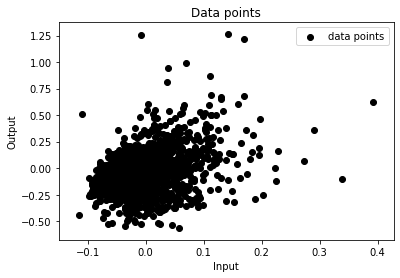

In [44]:
# plot of test data points
plt.scatter(x_test.mean(1),y_test,color='k',label='data points')
# plt.plot(x_test.mean(1),pred_y,'r',label='test',linewidth=2)

plt.title('Data points')
plt.xlabel('Input')
plt.ylabel('Output')

plt.legend()

plt.grid(False)

plt.show()

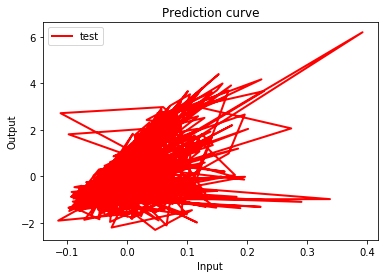

In [45]:
# plot of test data points
# plt.scatter(x_test.mean(1),y_test,color='k',label='data points')
plt.plot(x_test.mean(1),pred_y,'r',label='test',linewidth=2)

plt.title('Prediction curve')
plt.xlabel('Input')
plt.ylabel('Output')

plt.legend()

plt.grid(False)

plt.show()

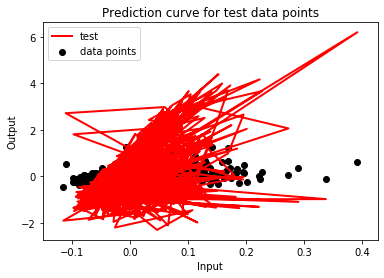

In [46]:
# plot of test data points
plt.scatter(x_test.mean(1),y_test,color='k',label='data points')
plt.plot(x_test.mean(1),pred_y,'r',label='test',linewidth=2)

plt.title('Prediction curve for test data points')
plt.xlabel('Input')
plt.ylabel('Output')

plt.legend()

plt.grid(False)

plt.show()

In [47]:
sc_Y.inverse_transform(pred_y)

array([110381.10885147, 152972.89479582, 185047.94427628, ...,
       173366.35860699, 117854.8822939 , 216754.82377284])

In [48]:
y_test[:1]

array([-0.14662344])

In [49]:
temp = pd.read_csv('sample_submission.csv')

In [50]:
temp.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [51]:
temp['SalePrice'] = sc_Y.inverse_transform(pred_y)

In [52]:
temp.head()

,Id,SalePrice
0,1461,110381.108851
1,1462,152972.894796
2,1463,185047.944276
3,1464,193097.629345
4,1465,207944.301885


In [53]:
temp.to_csv('submission.csv',index=False)

In [54]:
len(temp)

1459